In [1]:
import pandas as pd
import glob
import math
import contractions
from nltk.corpus import stopwords
from nltk import word_tokenize
import keras
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import plot_model, vis_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import emoji
import string


/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Data has been preprocessed by removing all the " characters: sed -i 's/"//g' *.txt
# as this caused issues reading the data as a csv file. 
# Also had to remove a blank line from subtask A 2016 test data 
# TODO instead change the quote char in the read_csv call

# Load the data
fileGlob = glob.glob('./task3Data/*.txt')

traindf = pd.concat([pd.read_csv(f, sep='\t', header=None, keep_default_na=False) for f in fileGlob], ignore_index = True)
traindf.columns = ['id','topic','label','raw']
#traindf = traindf.drop(['date'], axis=1)

# Things to try:
Convert the text into vector my using a pre-trained system. 
Convert text into a vector by using a NN to train the embeddings. 

Looks like i need to handle the weird character replacement that's happening

In [15]:
# Need to do some preprocessing on the data to remove stop words, punctuation and probably stem the words too. 
# Need to handle the /u002c and other unicdoe character artifacts that are happening. 
# If removing punctuation then may want to simply remove them 
# but if expanding contractinons will need to convert them first. - a library exists to do this
# Need to check to see what's happening with emojis



In [61]:
def preprocess(tweet, stop_words, target):
    # Handle utf8 unicode problems
    #print(tweet)
    #tweet = emoji.demojize(tweet)
    
    tweet = tweet.encode('utf8').decode('unicode_escape', 'ignore') 
    tweet = contractions.fix(tweet)
    tweet = tweet.lower()
    if target.lower() in tweet:
        tweet = tweet.replace(target,"<TARGETTOKEN>")
        
    tweetLine = word_tokenize(tweet)
    # remove all tokens that are not alphabetic or stopwords, also lower the words
    tweetLine = [word for word in tweetLine if word not in stop_words and word not in string.punctuation]
    return tweetLine

stop_words = stopwords.words('english')

traindf['text'] = traindf.apply(lambda row: preprocess(row['raw'], stop_words, row['topic']),axis=1)


/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\_'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\m'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\,'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\o'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\l'
  


In [62]:
# Sanity check to ensure tweets are tweet length
maxi = 0
for text in traindf.text:
    length = len(' '.join(text))
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

maxi = 0
for text in traindf.text:
    length = len(text)
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

181
['5th', 'day', 'TARGETTOKEN', 'eid', 'like', 'boys', 'TARGETTOKEN', 'eid', 'khtam', 'hogayi', 'h', 'kanjar', 'ki', 'olaad', 'itna', 'tyar', 'shyaar', 'q', 'hai', 'girls', 'TARGETTOKEN', 'eid', 'mubarak', 'TARGETTOKEN', 'eid', 'mubarak', 'TARGETTOKEN', 'eid', 'mubarak']
41
['work', 'friday', 'night', 'lt', 'lt', 'lt', 'lt', 'lt', 'TARGETTOKEN', 'venice', 'beach', 'bound', 'morning', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt']


In [63]:
pd.options.display.max_colwidth = 10000
sample = traindf.loc[traindf.id == 641648318754516992]

print(sample.raw.item())
print(sample.text.item())
print(sample.label.item())
print(sample.topic.item())
sampleLine = preprocess(sample.raw.item(),stop_words, sample.topic.item())
print(sampleLine)
print(sample.topic.item() in sample.raw.item().lower())

I can't stop thinking about the fact that I'm going to be in the presence of Snoop Dogg on Sunday
['stop', 'thinking', 'fact', 'going', 'presence', 'TARGETTOKEN', 'snoop', 'dogg', 'sunday']
2
snoop dogg
['stop', 'thinking', 'fact', 'going', 'presence', 'TARGETTOKEN', 'snoop', 'dogg', 'sunday']
True


In [64]:
# create index-word relationship
word2idx = {'<PAD>': 0, '<UNK>' : 1,'TARGETTOKEN' : 2 }
idx2word ={}
sents_as_ids = []
for line in traindf.text:
    sentId = []
    for word in line:
        if word in word2idx:
            sentId.append(word2idx[word])
            continue
        count = len(word2idx)
        word2idx[word] = count
        idx2word[count] = word
        sentId.append(count)
    sents_as_ids.append(sentId)
    

In [65]:
def convertTextToNumSeq(text, word2idx,MAXIMUM_LENGTH):
    numSeq = []
    for word in text:
        if word in word2idx:
            numSeq.append(word2idx[word])
        else:
            # If unseen put in unknown
            numSeq.append(1) 
                
    numSeq = pad_sequences([numSeq],MAXIMUM_LENGTH )
    return numSeq

MAXIMUM_LENGTH = 50 # Motivated because max sequence of words i had was 32

traindf['numSeq'] = traindf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)

In [66]:
x_train, x_val, y_train, y_val = train_test_split(traindf.numSeq, traindf.label, stratify=traindf.label, random_state =2)
labelDist = y_val.value_counts()
print(labelDist)
x_train = np.array([x for y in x_train for x in y]).reshape(len(x_train),MAXIMUM_LENGTH)
x_val = np.array([x for y in x_val for x in y]).reshape(len(x_val),MAXIMUM_LENGTH)


labelCount = len(labelDist)
#Y data is categorical therefore must be converted to a vector
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
y_train = onehot_encoder.fit_transform(np.array(y_train).reshape(len(y_train),1))
y_val = onehot_encoder.transform(np.array(y_val).reshape(len(y_val),1))

 0    3248
 1    3230
-1     850
 2     255
-2      75
Name: label, dtype: int64


In [67]:
VOCAB_SIZE = 10000

EMBED_SIZE = 100
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE,input_length=MAXIMUM_LENGTH))
model.add(LSTM(100))

model.add(Dense(labelCount, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 1,080,905
Trainable params: 1,080,905
Non-trainable params: 0
_________________________________________________________________


In [68]:


history = model.fit(x_train,y_train,epochs=5,batch_size=128,validation_data=(x_val, y_val),verbose=1)

Train on 22974 samples, validate on 7658 samples
Epoch 1/5
22974/22974 [==============================] - 15s 665us/step - loss: 1.1045 - acc: 0.4994 - val_loss: 0.9665 - val_acc: 0.5770
Epoch 2/5
22974/22974 [==============================] - 15s 634us/step - loss: 0.8768 - acc: 0.6287 - val_loss: 0.9482 - val_acc: 0.5845
Epoch 3/5
22974/22974 [==============================] - 15s 644us/step - loss: 0.7866 - acc: 0.6720 - val_loss: 0.9495 - val_acc: 0.5921
Epoch 4/5
22974/22974 [==============================] - 15s 655us/step - loss: 0.7194 - acc: 0.7067 - val_loss: 1.0005 - val_acc: 0.5778
Epoch 5/5
22974/22974 [==============================] - 15s 637us/step - loss: 0.6608 - acc: 0.7322 - val_loss: 1.0432 - val_acc: 0.5765


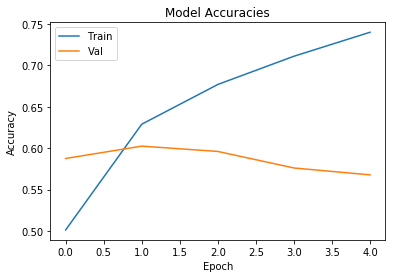

In [58]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

In [13]:
# With stop word removal,string.punctuation word removal, vocab size 10000, padding at 50, get 0.60 val accuracy 
# adding in TARGETTOKEN  increased accuracy by less than 1% 

In [29]:
y_pred = model.predict(x_val)
y_pred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_pred])
y_pred_text = onehot_encoder.inverse_transform(y_pred)
y_val_text = onehot_encoder.inverse_transform(y_val)

In [30]:
cm = confusion_matrix(y_val_text, y_pred_text)

In [59]:
# Rows are the actual, columns are the predicted.  negative, neutral, positve
print(cm)

[[   3   32   24   16    0]
 [   4  200  482  163    1]
 [   1  182 2121  941    3]
 [   1   80 1022 2101   26]
 [   0    5   24  214   12]]


In [60]:
(cm[0][0] + cm[1][1] + cm[2][2] +cm[3][3] + cm[4][4])/sum(sum(cm))

0.5793940976756333